In [ ]:
import os
import time
import re
import warnings
import copy
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
%reload_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [ ]:
!pip install timm
!pip install pytorch_ranger
!pip install ttach

     |████████████████████████████████| 184kB 2.8MB/s 


In [ ]:
import timm
from pytorch_ranger import Ranger   # optimiser
import ttach as tta    # test time augmentations

In [ ]:
def seed_everything(seed):
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)

seed_everything(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [ ]:
# DOWNLOAD DATASETS
!wget -q https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip
!wget -q https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip
!wget -q https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_sDO3m7O.csv

!unzip -qo train_DETg9GD.zip
!unzip -qo test_Bh8pGW3.zip 

!rm -r test_Bh8pGW3.zip
!rm -r train_DETg9GD.zip

In [ ]:
# LOADING DATASET
traincsv = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission_sDO3m7O.csv')
col_class = sample['Class']
col_class = pd.DataFrame(col_class, columns=['Class'])
test = pd.concat([test, col_class], axis=1)
traincsv.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [ ]:
classes = np.unique(traincsv['Class'])
num_classes = len(classes)
print(classes)
print(num_classes)

['MIDDLE' 'OLD' 'YOUNG']
3


In [ ]:
traincsv

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
...,...,...
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE


In [ ]:
def showimg(img, unnormalize=True):
  if unnormalize:
    img = img * 0.5 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

def plot_loss(train, val):
  x = np.arange(1, len(train)+1)
  plt.figure(figsize=(10,6))
  plt.plot(x, train, label='Training Loss')
  plt.plot(x, val, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses!')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
# MAKING DATALOADER
class load_data(Dataset):
  def __init__(self, df, root, phase):
    self.df = df
    self.dir = root
    if phase == 'train':
      self.transforms = A.Compose([A.Resize(64,64),
                        #albu.SmallestMaxSize(64),
                        #albu.RandomCrop(64,64),
                        A.HorizontalFlip(p=0.5),
                        A.RandomBrightness(),
                        A.HueSaturationValue(-1,1),
                        A.RGBShift(),
                        A.Rotate(limit=(-45,45)),
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ToTensor()])
    else:
      self.transforms = A.Compose([A.Resize(64,64),
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ToTensor()])

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_id = self.df['ID'].iloc[idx]
    img_path = os.path.join(self.dir, str(img_id))
    labels = self.df.iloc[idx, 1:].to_numpy()
    labels = np.argmax(labels)
    img = plt.imread(img_path)
    img = self.transforms(image=np.array(img))['image']
    return img, labels

In [ ]:
def cvrt_to_dumm(data):
  data = pd.get_dummies(data, columns=['Class'], prefix='Class')
  return data

In [ ]:
# SPLITTING DATASET INTO TRAINING AND VALIDATION SET
sfk = StratifiedKFold(n_splits=7)
for trn_idx, val_idx in sfk.split(traincsv['Class'], traincsv['Class']):
    train = pd.DataFrame(traincsv.loc[trn_idx].values)
    val = pd.DataFrame(traincsv.loc[val_idx].values)
val.rename(columns={0:'ID',1:'Class'}, inplace=True)
train.rename(columns={0:'ID',1:'Class'}, inplace=True)
train = cvrt_to_dumm(train)
val = cvrt_to_dumm(val)
train.head()

,ID,Class_MIDDLE,Class_OLD,Class_YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0


In [ ]:
batch_size = 32

In [ ]:
train

,ID,Class_MIDDLE,Class_OLD,Class_YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0
...,...,...,...,...
17058,1791.jpg,0,0,1
17059,25007.jpg,0,0,1
17060,6886.jpg,0,0,1
17061,15511.jpg,0,0,1


In [ ]:
#DEFINING DATALOADER
trainset = load_data(train, 'Train', 'train')
valset = load_data(val, 'Train', 'eval')
testset = load_data(test, 'Test', 'eval')
tdl = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
vdl = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
testdl = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    MIDDLE     MIDDLE     MIDDLE     MIDDLE      YOUNG      YOUNG     MIDDLE      YOUNG        OLD      YOUNG        OLD     MIDDLE     MIDDLE     MIDDLE      YOUNG     MIDDLE      YOUNG      YOUNG     MIDDLE      YOUNG     MIDDLE     MIDDLE     MIDDLE     MIDDLE     MIDDLE     MIDDLE      YOUNG      YOUNG      YOUNG     MIDDLE      YOUNG     MIDDLE


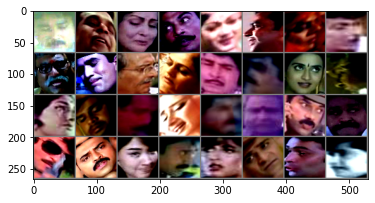

In [ ]:
# SHOWING IMAGES 
images, label = next(iter(tdl))
showimg(torchvision.utils.make_grid(images))
print(' '.join('{:>10}'.format(classes[label[j]]) for j in range(batch_size)))

In [ ]:
#DEFINING TRAINER
def train_model(model, dataloader, criterion, optimizer, scheduler, epochs, verbose=False, print_every=25, load_model=False):
  since = time.time()
  train_history = []
  val_history = []
  best_loss = np.inf

  if load_model:
    checkpoint = torch.load('model.pth')
    model.load_state_dict(checkpoint['state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']

  best_model = model.state_dict()
  train_ldr = dataloader['train']
  val_ldr = dataloader['val']

  model.train()
  for epoch in range(1, epochs+1):
    print('Epoch: {} of {}'.format(epoch, epochs))
    start = time.time()
    total_train_loss = 0.0
    running_acc = 0.0
    for i, (img, labels) in enumerate(dataloader['train']):
      img, labels = img.to(device), labels.to(device)
      optimizer.zero_grad()

      score = model(img)
      loss = criterion(score, labels)
      loss.backward()
      optimizer.step()
      _, pred = torch.max(score, dim=1)
      running_acc += torch.sum(pred==labels.data)
      
      total_train_loss += loss.item()*img.size(0)

      if (i) % (print_every) == 0 and verbose:    
                print("Completed {:d}% of 100%".format(int(100 * (i) / len(dataloader['train']))))

    epoch_train_acc = running_acc.double() / len(dataloader['train'].dataset)
    timer = time.time() - start
    print('Train Loss: {:.4f} \t Train accuracy: {:.4f} \t took {}m {}s'.format(total_train_loss / len(dataloader['train'].dataset),
                                                             epoch_train_acc.item(), timer//60, timer%60))
    train_history.append(total_train_loss / len(dataloader['train'].dataset))

    # EVALUATING 

    model.eval()
    total_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
      for (img, labels) in dataloader['val']:
        img, labels = img.to(device), labels.to(device)
        val_score = model(img)
        val_loss = criterion(val_score, labels)
        total_val_loss += val_loss.item() * img.size(0)
        _, vpred = torch.max(val_score, dim=1)
        running_val_acc += torch.sum(vpred==labels.data)
      
    epoch_val_loss = total_val_loss / len(dataloader['val'].dataset)
    val_history.append(epoch_val_loss)
    val_acc = running_val_acc / len(dataloader['val'].dataset)
    state = {'epoch':epoch, 'best_loss':best_loss,
             'state':model.state_dict(), 'optimizer':optimizer.state_dict(),
             'scheduler':scheduler.state_dict()}
    
    if scheduler:
      scheduler.step(epoch_val_loss)
    if epoch_val_loss < best_loss:
      state['best_loss'] = best_loss = epoch_val_loss
      torch.save(state, 'model.pth')
      best_model = model.state_dict()
    
    print("Validation loss = {:.4f} \t Validation accuracy = {}".format(epoch_val_loss, val_acc))
    print('```````````````````````````````````````````````````````````')

  timer = time.time() - since
  print("Training Finished, took {}m {}s".format(timer//60, timer%60))

  return best_model, train_history, val_history

In [ ]:
def test_model(model, testldr, verbose=False):
  model.eval()
  final_pred = []
  with torch.no_grad():
    for (img, label) in testldr:
      img, label = img.to(device), label.to(device)
      output = model(img)
      _, pred = torch.max(output, dim=1)
      final_pred.append(pred.cpu().numpy().data)
    if verbose:
      print('Done evaluating, finishing up...')
    final_pred = np.concatenate(final_pred)
    testcopy['Class'] = final_pred
  return testcopy

In [ ]:
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=3, drop_rate=0.2)

In [ ]:
model_classes = model.classifier.in_features

In [ ]:
model.classifier = nn.Sequential(nn.Linear(model_classes, num_classes*2), nn.Dropout(0.2), nn.ReLU(), nn.Linear(num_classes*2, num_classes))
model = model.to(device)
#optimizer = optim.Adam(model.fc.parameters(), lr=2e-4, betas=(0.9, 0.999),weight_decay=0.001)
optimizer = Ranger(model.parameters(), lr=2e-4, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, mode='min', threshold=0.01, patience=3, verbose=True)
dataldr = {'train': tdl, 'val':vdl}

In [ ]:
best_model, train_hist, val_hist = train_model(model,  dataldr, criterion, optimizer, scheduler, 50, print_every=40, verbose=True, load_model=False)

Epoch: 1 of 50
Completed 0% of 100%
Completed 7% of 100%
Completed 14% of 100%
Completed 22% of 100%
Completed 29% of 100%
Completed 37% of 100%
Completed 44% of 100%
Completed 52% of 100%
Completed 59% of 100%
Completed 67% of 100%
Completed 74% of 100%
Completed 82% of 100%
Completed 89% of 100%
Completed 97% of 100%
Train Loss: 0.8648 	 Train accuracy: 0.6146 	 took 2.0m 8.220670700073242s
Validation loss = 0.7632 	 Validation accuracy = 0.6704185605049133
```````````````````````````````````````````````````````````
Epoch: 2 of 50
Completed 0% of 100%
Completed 7% of 100%
Completed 14% of 100%
Completed 22% of 100%
Completed 29% of 100%
Completed 37% of 100%
Completed 44% of 100%
Completed 52% of 100%
Completed 59% of 100%
Completed 67% of 100%
Completed 74% of 100%
Completed 82% of 100%
Completed 89% of 100%
Completed 97% of 100%
Train Loss: 0.6939 	 Train accuracy: 0.6997 	 took 2.0m 4.086702346801758s
Validation loss = 0.6070 	 Validation accuracy = 0.738304615020752
`````````````

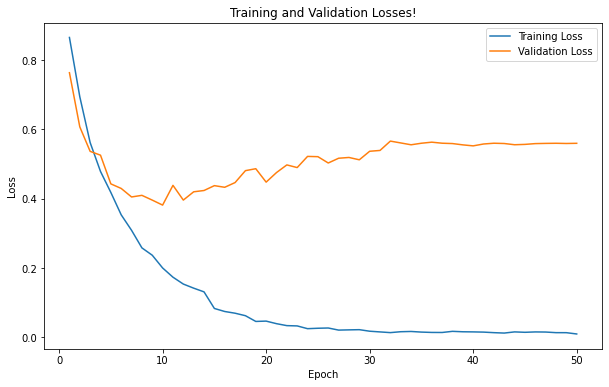

In [ ]:
# LOSS CURVE
plot_loss(train_hist, val_hist)

In [ ]:
# TEST TIME TRANSFORMS
test_tf = tta.Compose([tta.HorizontalFlip(), tta.Multiply(factors=[0.9, 1, 1.1])])
tta_model = tta.ClassificationTTAWrapper(model, test_tf, merge_mode = 'mean')

In [ ]:
testcopy = test.copy()
prediction = test_it(tta_model, testdl, verbose=True)
prediction.head()

Done evaluating, finishing up...


,ID,Class
0,25321.jpg,0
1,989.jpg,2
2,19277.jpg,0
3,13093.jpg,0
4,5367.jpg,0


In [ ]:

mapper = {'Class':{0:'MIDDLE', 1:'OLD', 2:'YOUNG'}}
prediction.replace(mapper, inplace=True)
new_col = ['Class', 'ID']
prediction = prediction.reindex(columns=new_col)
prediction.head()

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [ ]:
prediction.to_csv('Kfold50.csv', index=False)